# K_ras affinity prediction

In [1]:
import pickle

with open('result/agent/kras_kd//kras_kd_pred_eval.pkl', 'rb') as f:
    y_val, y_test, y_val_hat, y_test_hat, spearman = pickle.load(f)

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


x range: -1.6989700043360187 2.903089986991944
y range: -1.8061796 1.3469294


findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


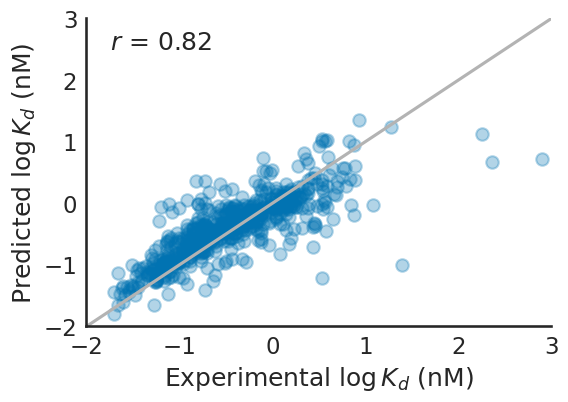

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from utils import plot_style_utils

plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()

ax.scatter(y_val, y_val_hat, alpha=0.3, label='Val', color=plot_style_utils.CAT_PALETTE[0])
ax.scatter(y_test, y_test_hat, alpha=0.3, label='Test', color=plot_style_utils.CAT_PALETTE[0])

ax.set_xlabel('Experimental $\log K_d$ (nM)')
ax.set_ylabel('Predicted $\log K_d$ (nM)')
print('x range:', min(np.min(y_val), np.min(y_test)), max(np.max(y_val), np.max(y_test)))
print('y range:', min(np.min(y_val_hat), np.min(y_test_hat)), max(np.max(y_val_hat), np.max(y_test_hat)))
minv = -2
maxv =3
ax.set_xlim([minv, maxv])
ax.set_ylim([minv, maxv])
ax.plot([minv, maxv], [minv, maxv], '-', color=[0.7, 0.7, 0.7])
ax.text(0.05, 0.9, '$\it{r}$ = %0.2f'%spearman[0], transform=ax.transAxes)

plot_style_utils.prettify_ax(ax)
plot_style_utils.save_for_pub(fig=fig, path='figures/kras_kd/kras_kd_pred_scatter')


# Predictive model evals

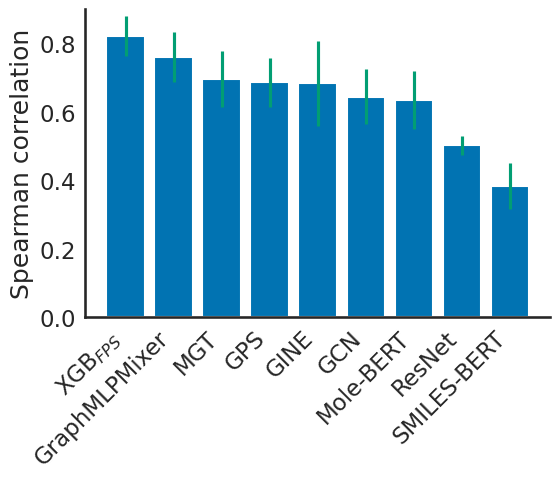

In [3]:
import numpy as np
from utils import plot_style_utils

methods = ['XGB$_{FPS}$', 'GraphMLPMixer', 'MGT', 'GPS', 'GINE', 'GCN', 'Mole-BERT', 'ResNet', 'SMILES-BERT']
spearman = [0.822, 0.761, 0.696, 0.686, 0.683, 0.644, 0.635, 0.502, 0.382]
spearman_std = [0.058, 0.073, 0.082, 0.072, 0.124, 0.081, 0.085, 0.028, 0.067]
plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax()
plot_style_utils.prettify_ax(ax)

ax.bar(methods, spearman, color=plot_style_utils.CAT_PALETTE[0])
ax.errorbar(methods, spearman, yerr=spearman_std, fmt='none', ecolor=plot_style_utils.CAT_PALETTE[2])
ax.set_ylabel('Spearman correlation')
ax.set_ylim([0,0.9])
ax.set_xticks(methods)
ax.set_xticklabels(methods, rotation=45, ha='right')
plot_style_utils.save_for_pub(fig=fig, path='figures/kras_kd/kras_kd_model_cmp')

# Plot feature importance

In [5]:
import joblib

model = joblib.load('data/kras_kd/kras_xgboost_reg.pkl')

importance = model.feature_importances_
indices = np.argsort(importance)[::-1]

top10_idx = indices[:10]
print(top10_idx)

[1572  689 1441  141 1885  580 1781 1139  741  463]


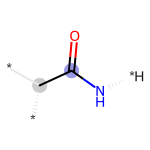

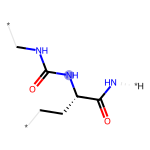

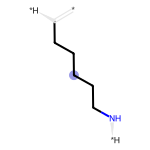

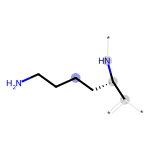

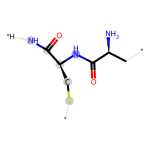

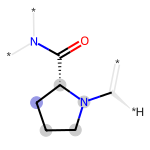

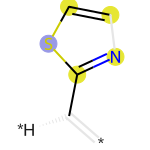

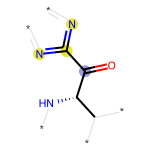

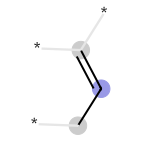

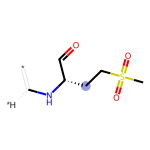

In [6]:
from rdkit import Chem
import numpy as np
from rdkit.Chem import AllChem, Draw
import pandas as pd


top10_idx2imag = {}
smiles = pd.read_csv('data/prior/prior_data.csv')['cano_smi'].to_list() # 9

for smi in smiles:
    mol = Chem.MolFromSmiles(smi) if type(smi) == str else None
    if mol is None:
        continue

    bit={}
    morganfp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=2048,  bitInfo=bit)

    mfpvector = np.array(morganfp)
    # print(np.nonzero(mfpvector))

    for idx in top10_idx:
        if idx not in bit:
            continue
        # print(idx, bit[idx])
        fig = Draw.DrawMorganBit(mol,idx, bit)
        if idx not in top10_idx2imag:
            display(fig)
            top10_idx2imag[idx] = fig   

    if len(top10_idx2imag) == len(top10_idx):
        break

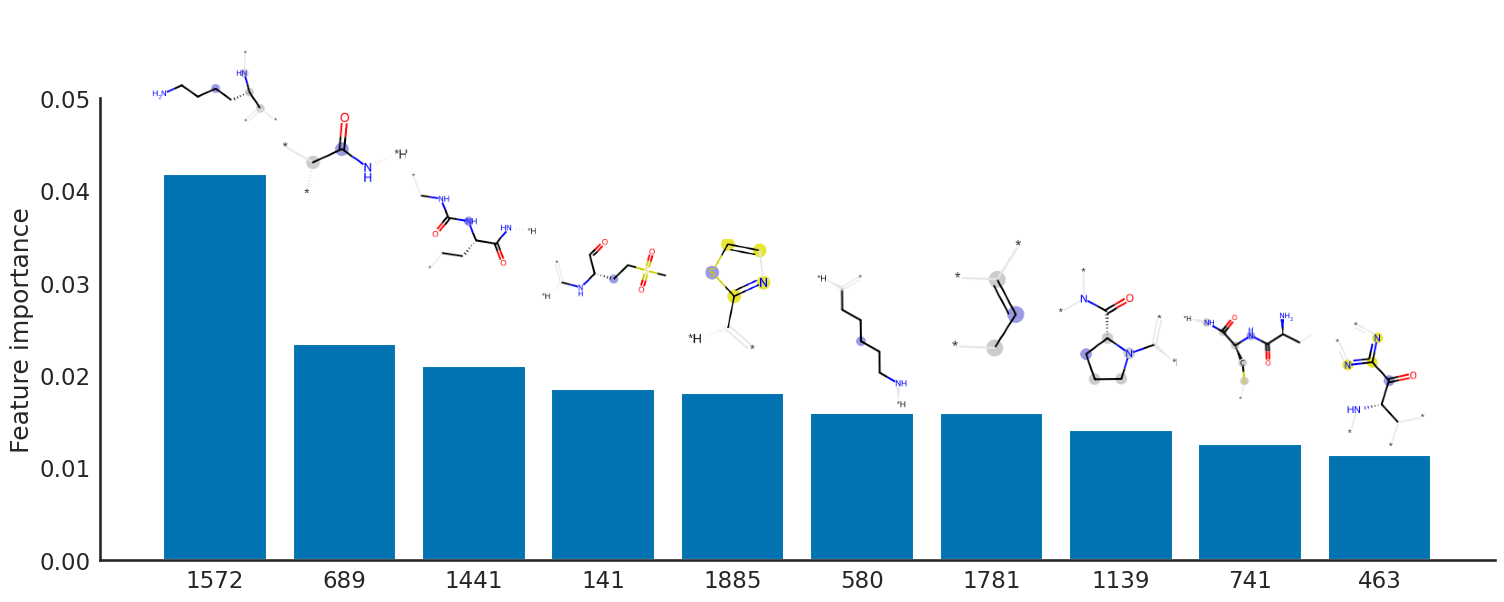

In [7]:
from utils import plot_style_utils
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Plot bar plot
plot_style_utils.set_pub_plot_context(context="talk")
fig, ax = plot_style_utils.simple_ax(figsize=(18, 6))
plot_style_utils.prettify_ax(ax)

# top_10_features = [features[indices[i]] for i in range(10)]
top_10_feature_importance = [importance[indices[i]] for i in range(10)]
ax.bar(range(10), top_10_feature_importance, color=plot_style_utils.CAT_PALETTE[0])
ax.set_ylabel('Feature importance')
ax.set_xticks(range(10))
ax.set_xticklabels([indices[i] for i in range(10)])


tick_labels = ax.xaxis.get_ticklabels()
img = [top10_idx2imag[i] for i in top10_idx]
heights = [-3, -2.5, -2.0, -1.65, -1.8, -1.0, -1.4, -1.2, -0.9, -0.8]
zoom_ins = [.65, .65, .65, .65, .55, .7, .65, .65, .7, .65]
for i,im in enumerate(img):
    ib = OffsetImage(im, zoom=zoom_ins[i])
    ib.image.axes = ax
    ab = AnnotationBbox(ib, tick_labels[i].get_position(), frameon=False,
                        box_alignment=(0.5, heights[i]))
    ax.add_artist(ab)

ax.set_ylim([0,0.05])
# plt.show()
plot_style_utils.save_for_pub(fig=fig, path='figures/kras_kd/kras_kd_pred_feature_importance')